**Course Project:** AIGC Detection

# CS5489 - Course Project (2024A)


# Course Project -AIGC Detection



## Introduction

This project comes from an important detection task. Recentadvances in deep learning, particularly in generative adversarial networks (GANs) and diffusion models, have significantly increased the photorealism of generated content. Whilethese techniques have entertaining applications, their potential weaponization has raised serious concerns. Detecting AI-generated content (AIGC) has become a pressing issue and a prominent research topic.

![Introduction](imgs/introduction.png)

**Fig 1** - Campairing real image(left) with AIGC image(right)

## Overview of Our Work

Our work can be devided to the following parts:

- **Data Loading and Preprocessing**: Beacuse the dataset we need to train and validate has been provided. What we need to do here is loading in the dataset and processing  the data to suit the model training.

- **Models Building**: We will build various models based on the VGG, ResNet50, MobileNet and EfficientNet. All the models share the same architecture for a fair comparison. 

- **Training and Evaluation**: After building the models, we will train them using the training dataset and evaluate them using the validation dataset. Through the training and validation performances, we will select the suitable model for our task.

- **Testing and Analysis**: After selecting the best model, we will evaluate it using the test dataset. We will analyze the model's performance using relevant metrics such as precision, recall, and accuracy. Additionally, we will analyze the model's ability to detect AIGC content and discuss its limitations.

## Data Loading and Preprocessing

First, we need to import all the dependencies, and check if GPU is available for training 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers


In [3]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In order to load the dataset, we need to know the structure of the dataset. It is shown below:

dataset/  
├── train/  
│   ├── 0_real/  
│   │   ├── img1.jpg  
│   │   ├── img2.jpg  
│   ├── 1_fake/  
│       ├── img3.jpg  
│       ├── img4.jpg  
├── val/  
    ├── 0_real/  
    ├── 1_fake/  

In the "0_real" class, the photographic images, with arbitrary sizes, are gathered from the ImageNet dataset.   
In the "1_fake" class, the AI-generated images, with a fixed size of 512 × 512 × 3, arecreated using the text-to-image diffusion model Stable Diffusionv1.4, which is trained on the LAION dataset containing billions of image-text pairs.  

Now, we can load the dataset using TensorFlow's image_dataset_from_directory function. This function will automatically load and preprocess the images, which will save us a lot of time and effort. The function expects images to be organized in subdirectories under dataset_dir + "/train" and dataset_dir + "/val". Each subdirectory represents a class, and its name is used as the class label.

All images are resized to (64, 64) to ensure uniformity for input to the model. For this downscaling, we applied Bilinear Interpolation rather than Nearest Neighbor Interpolation. Though Nearest Neighbor Interpolation retains sharp edges and boundaries  and processes very fast, it may result in jagged or pixelated edges. At the same time, Bilinear Interpolation produces smooth and natural transitions in resized images.The preprocessing is performed dynamically as the data is loaded, reducing memory usage.  
 
Then, images are grouped into batches of size 500. This allows the model to process multiple images simultaneously during training or validation.




In [4]:
img_height = 64
img_width = 64
batch_size = 500
dataset_dir = "E:/AIGCDetect/AIGC-Detection-Dataset" 
print("Loading dataset from: " + dataset_dir)
# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/val",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 45000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training Classes:
['0_real', '1_fake']
Testing Classes:
['0_real', '1_fake']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 45,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [5]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['0_real', '1_fake']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

## Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the ImageNet, then a few dense layers, and then a unit output with a sigmoid activation function. Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.


### ResNet50 Model

ResNet[1] introduced skip connections or "shortcuts," allowing gradients to flow more easily during backpropagation. This innovation combats the vanishing gradient problem, enabling deeper networks to perform exceptionally well. Its efficiency and accuracy make it a staple for classification and detection tasks. The core idea is Instead of learning a direct mapping from input to output, ResNet learns residuals (the difference between the input and the output).
This is achieved using skip connections, where the input of a layer bypasses one or more layers and is added to the output.  
**Formula:**   
𝑦=𝐹(𝑥)+𝑥  
Here, x is the input, and 𝐹(𝑥) is the transformation performed by the network layers. The whole structure is shown below:  

![ResNet50 Architecture](imgs/resnet50.png)

**Fig 2** ResNet50

In [6]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                             

### VGG Model

VGGNet[2] is known for its simplicity and effectiveness. It uses small convolutional filters and increases the network depth significantly, enabling better feature extraction. While computationally intensive, it serves as a solid baseline for image classification tasks.VGG networks consist of convolutional layers stacked in a sequential manner with small filter sizes (3×3). The architecture is simple and modular, making it easy to implement and adapt.The whole structure is shown below:  

![VGG Model](imgs/VGG.png)

**Fig 3** VGGNet

In [ ]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                           

### MobileNet Model

MobileNet[3] is a groundbreaking architecture for resource-constrained environments, providing a balance between accuracy and computational efficiency. It is widely used in mobile and IoT applications, as well as in transfer learning for custom vision tasks. MobileNet is designed to balance accuracy and efficiency, targeting devices with limited computational power like smartphones, IoT devices, and embedded systems. MobileNet replaces standard convolutions with depthwise separable convolutions(shown as below). This reduces computation and parameter count significantly while maintaining performance.

![MobileNet Model](imgs/MobileNet.png)

**Fig 4** Left: Standard convolutional layer with batchnorm and ReLU.  
Right: Depthwise Separable convolutions with Depthwise and Pointwise layers followed by batchnorm and ReLU.


In [ ]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 MobilenetV3small (Functiona  (None, 576)              939120    
 l)                                                              
                                                                 
 batch_normalization_5 (Batc  (None, 576)              2304      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 256)               147712    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                1644

### EfficientNet Model

EfficientNet[4] is a family of convolutional neural networks developed by Google AI. EfficientNet introduces a novel compound scaling method to balance three dimensions of network scaling(shown as the following figure):
- **Depth**: Number of layers in the model.
- **Width**: Number of channels in each layer.
- **Resolution**: Input image size.  

![EfficientNet Model](imgs/EfficientNet.png)

Deeper ConvNet can capture richer and more complex features and generalize well on new tasks. However, deeper networks are also more difficult to train due to the vanishing gradient problem. Wider networks tend to be able to capture more fine-grained features and are easier to train. However, extremely wide but shallow networks tend to have difficulties in capturing higher level features. With higher resolution input images, ConvNets can potentially capture more fine-grained patterns. but accuracy gain diminishes for very high resolutions. Unlike traditional scaling, which adjusts one dimension (e.g., increasing depth in ResNet), EfficientNet scales all three dimensions simultaneously in a principled manner.

The architecture of EfficientNet-B0 was discovered through Neural Architecture Search. It uses a combination of depthwise separable convolutions, inverted residual blocks (from MobileNetV2), and squeeze-and-excitation (SE) modules for efficiency and accuracy.


In [ ]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                1644

## Training and Evaluation

We refer to the confusion matrices, hoping to learn the True Positive, False Positive, True Negative, False Negative of the model after training and prediction, and to compute the other metrics through them as follows:

1. **Accuracy**: The proportion of all correctly predicted samples (both true and true negative examples) to the total number of samples. The formula is given below: $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

2. **Precision**: The proportion of samples predicted to be positive cases that are truly positive cases. The formula is given below:$$\text{Precision} = \frac{TP}{TP + FP}$$

3. **Recall**: The proportion of all correctly predicted true samples to all true samples. The formula is given below: $$\text{Recall} = \frac{TP}{TP + FN}$$

### ResNet50

In [7]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
Epoch 1/50
90/90 [==============================] - 24s 185ms/step - loss: 3.0235 - accuracy: 0.8166 - precision: 0.8264 - recall: 0.8017 - val_loss: 695.7356 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/50
90/90 [==============================] - 17s 185ms/step - loss: 1.3241 - accuracy: 0.8749 - precision: 0.8725 - recall: 0.8781 - val_loss: 3.1065 - val_accuracy: 0.5086 - val_precision: 0.5043 - val_recall: 1.0000
Epoch 3/50
90/90 [==============================] - 18s 190ms/step - loss: 0.7847 - accuracy: 0.8949 - precision: 0.8935 - recall: 0.8967 - val_loss: 0.9595 - val_accuracy: 0.8072 - val_precision: 0.7271 - val_recall: 0.9836
Epoch 4/50
90/90 [==============================] - 18s 189ms/step - loss: 0.5230 - accuracy: 0.9081 - precision: 0.9070 - recall: 0.9095 - val_loss: 529.0758 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/50
90/90 [===================

In [8]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

10/10 [==============================] - 2s 65ms/step - loss: 0.2768 - accuracy: 0.8950 - precision: 0.8533 - recall: 0.9540
Val Loss: 0.2768
Val Accuracy: 0.8950
Val Precision: 0.8533
Val Recall: 0.9540


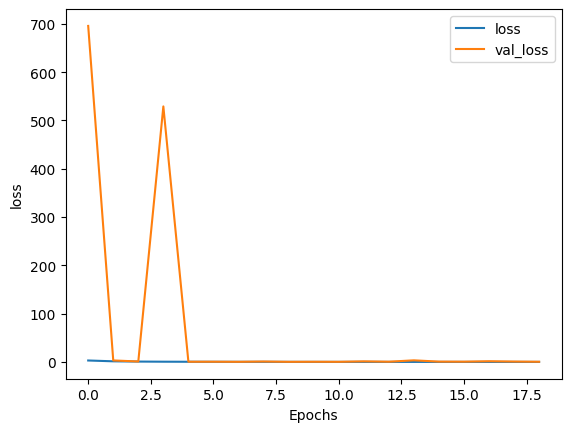

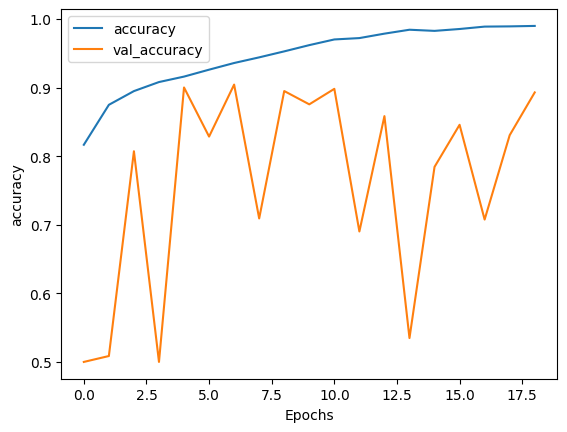

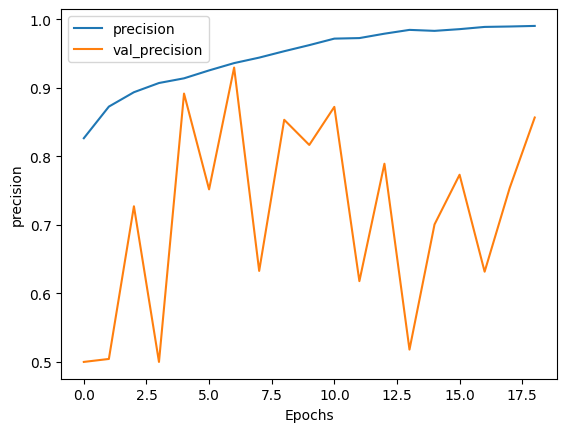

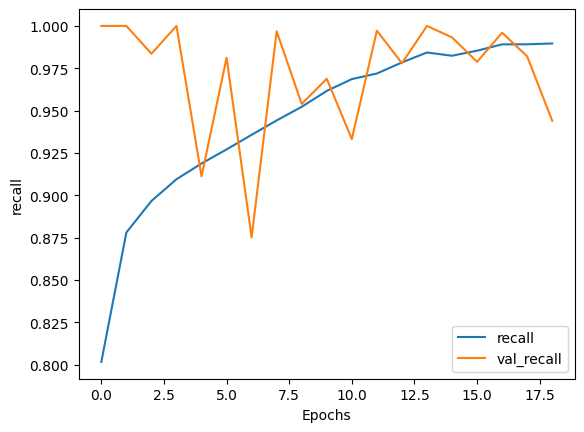

In [9]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')

### VGGNet

In [11]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...
Epoch 1/50
90/90 [==============================] - 43s 298ms/step - loss: 2.3732 - accuracy: 0.7503 - precision_1: 0.7775 - recall_1: 0.7012 - val_loss: 1.3598 - val_accuracy: 0.7916 - val_precision_1: 0.8240 - val_recall_1: 0.7416
Epoch 2/50
90/90 [==============================] - 28s 300ms/step - loss: 1.0038 - accuracy: 0.8085 - precision_1: 0.8401 - recall_1: 0.7621 - val_loss: 0.9796 - val_accuracy: 0.6324 - val_precision_1: 0.9811 - val_recall_1: 0.2700
Epoch 3/50
90/90 [==============================] - 28s 301ms/step - loss: 0.6404 - accuracy: 0.8425 - precision_1: 0.8620 - recall_1: 0.8157 - val_loss: 0.8721 - val_accuracy: 0.6272 - val_precision_1: 0.9953 - val_recall_1: 0.2556
Epoch 4/50
90/90 [==============================] - 28s 304ms/step - loss: 0.4796 - accuracy: 0.8657 - precision_1: 0.8762 - recall_1: 0.8518 - val_loss: 0.9325 - val_accuracy: 0.5628 - val_precision_1: 0.9968 - val_recall_1: 0.1260
Epoch 5/50
9

In [12]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

10/10 [==============================] - 2s 99ms/step - loss: 0.2728 - accuracy: 0.9018 - precision_1: 0.8922 - recall_1: 0.9140
Val Loss: 0.2728
Val Accuracy: 0.9018
Val Precision: 0.8922
Val Recall: 0.9140


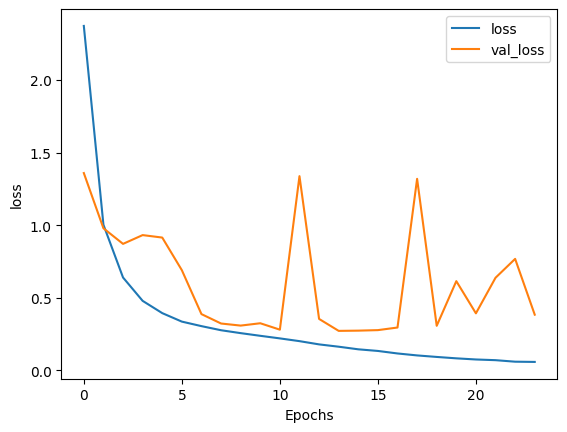

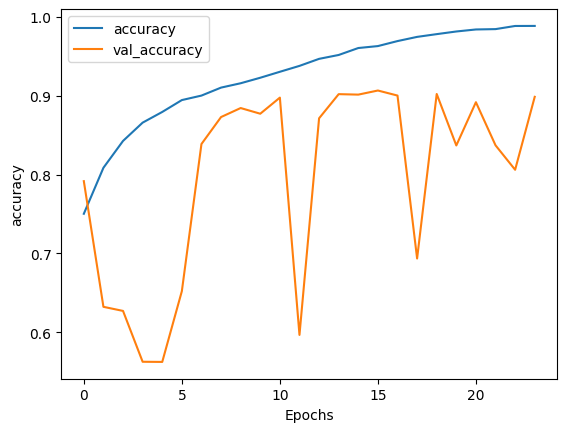

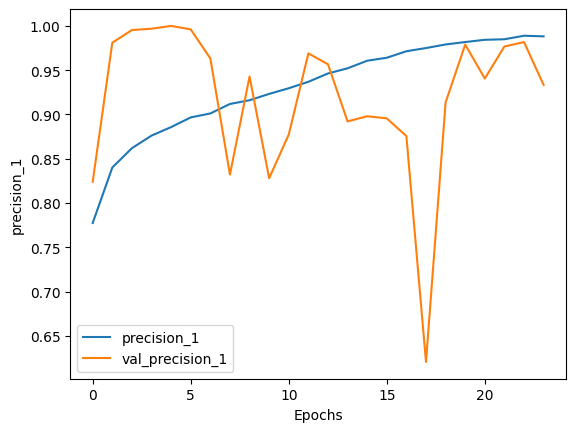

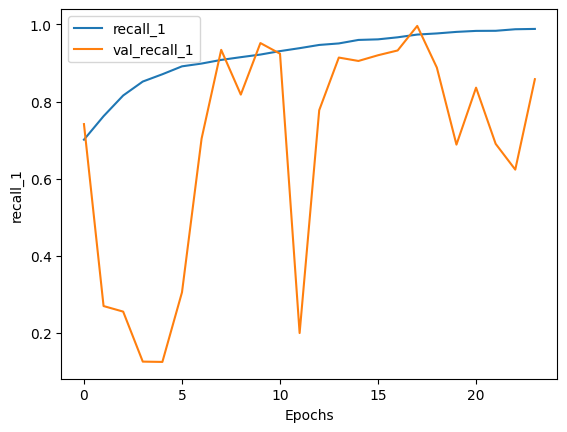

In [13]:
# Plot error rates and metric rates
plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')
plot_metrics(VGG_model_history, 'precision_1')
plot_metrics(VGG_model_history, 'recall_1')

### EfficientNet

In [15]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using EfficientNet...
Epoch 1/50
90/90 [==============================] - 21s 170ms/step - loss: 2.9826 - accuracy: 0.8316 - precision_2: 0.8290 - recall_2: 0.8356 - val_loss: 1.7478 - val_accuracy: 0.8486 - val_precision_2: 0.9739 - val_recall_2: 0.7164
Epoch 2/50
90/90 [==============================] - 16s 163ms/step - loss: 1.0124 - accuracy: 0.9252 - precision_2: 0.9238 - recall_2: 0.9268 - val_loss: 0.7196 - val_accuracy: 0.9120 - val_precision_2: 0.9640 - val_recall_2: 0.8560
Epoch 3/50
90/90 [==============================] - 16s 163ms/step - loss: 0.4820 - accuracy: 0.9465 - precision_2: 0.9447 - recall_2: 0.9485 - val_loss: 0.4169 - val_accuracy: 0.9200 - val_precision_2: 0.9738 - val_recall_2: 0.8632
Epoch 4/50
90/90 [==============================] - 16s 162ms/step - loss: 0.2881 - accuracy: 0.9580 - precision_2: 0.9573 - recall_2: 0.9586 - val_loss: 0.3237 - val_accuracy: 0.9112 - val_precision_2: 0.9795 - val_recall_2: 0.8400
Epoch

In [16]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

10/10 [==============================] - 2s 58ms/step - loss: 0.2290 - accuracy: 0.9480 - precision_2: 0.9473 - recall_2: 0.9488
Val Loss: 0.2290
Val Accuracy: 0.9480
Val Precision: 0.9473
Val Recall: 0.9488


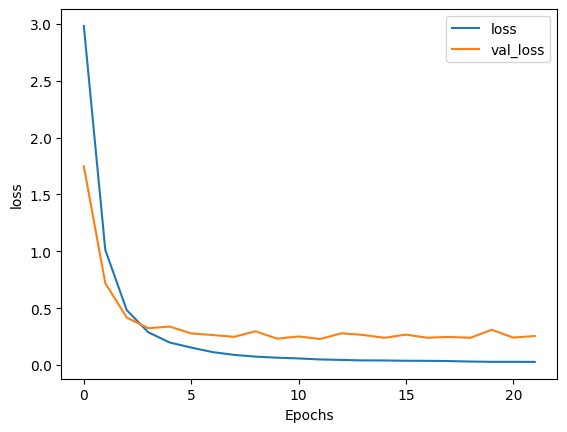

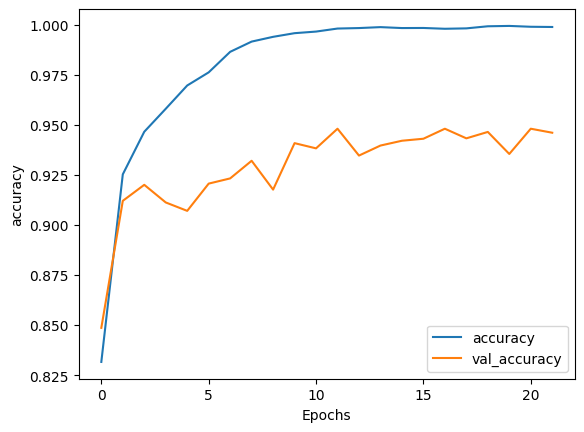

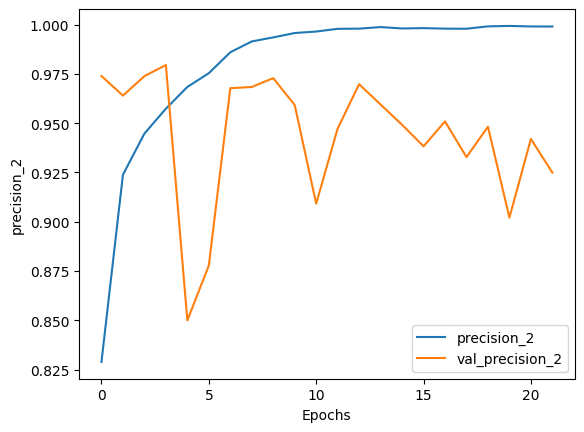

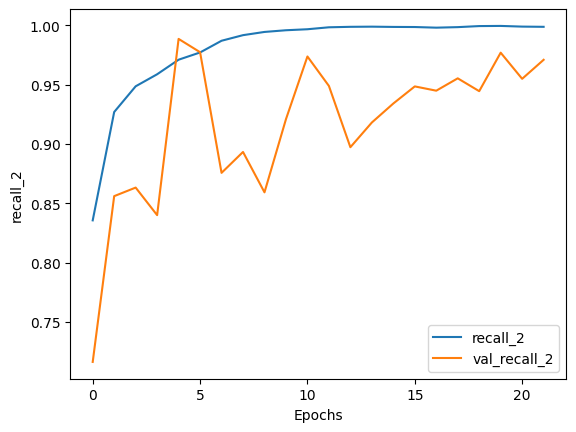

In [17]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision_2')
plot_metrics(EfficientNet_model_history, 'recall_2')

### MobileNet

In [20]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...
Epoch 1/50
90/90 [==============================] - 18s 157ms/step - loss: 1.8078 - accuracy: 0.7681 - precision_3: 0.7764 - recall_3: 0.7532 - val_loss: 1.9141 - val_accuracy: 0.5778 - val_precision_3: 0.5422 - val_recall_3: 0.9992
Epoch 2/50
90/90 [==============================] - 14s 141ms/step - loss: 0.3702 - accuracy: 0.8757 - precision_3: 0.8755 - recall_3: 0.8760 - val_loss: 1.4617 - val_accuracy: 0.6052 - val_precision_3: 0.5588 - val_recall_3: 0.9992
Epoch 3/50
90/90 [==============================] - 14s 143ms/step - loss: 0.2797 - accuracy: 0.9030 - precision_3: 0.9010 - recall_3: 0.9055 - val_loss: 0.9296 - val_accuracy: 0.6446 - val_precision_3: 0.5846 - val_recall_3: 0.9996
Epoch 4/50
90/90 [==============================] - 14s 142ms/step - loss: 0.2425 - accuracy: 0.9168 - precision_3: 0.9150 - recall_3: 0.9190 - val_loss: 0.3223 - val_accuracy: 0.8846 - val_precision_3: 0.8317 - val_recall_3: 0.9644
Epoch 5/

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

10/10 [==============================] - 2s 44ms/step - loss: 0.3085 - accuracy: 0.8976 - precision_3: 0.8604 - recall_3: 0.9492
Val Loss: 0.3085
Val Accuracy: 0.8976
Val Precision: 0.8604
Val Recall: 0.9492


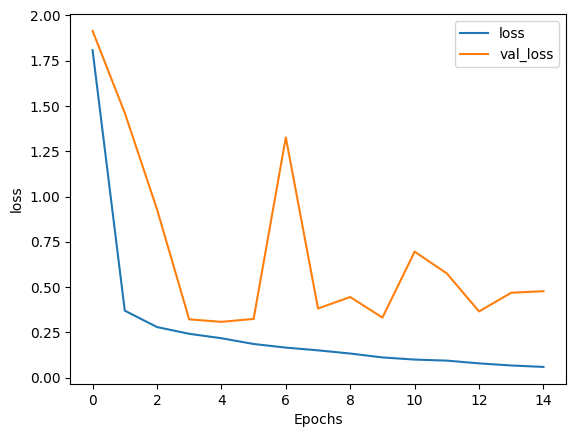

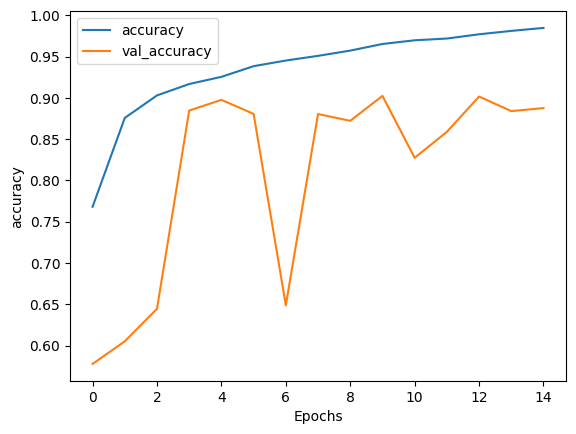

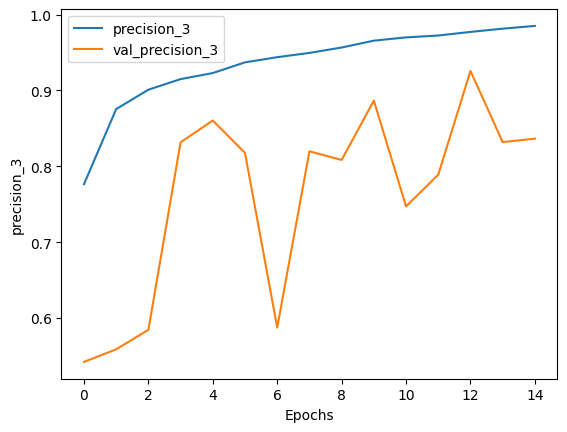

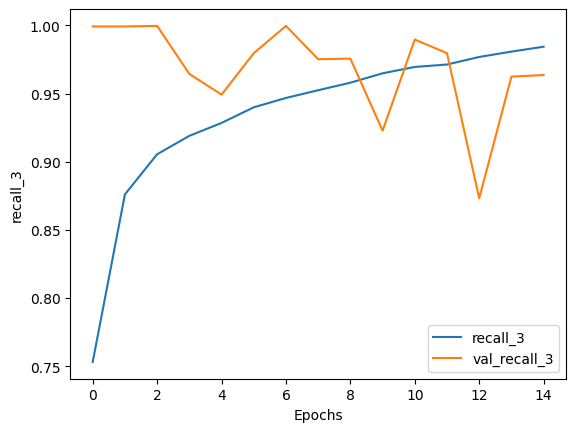

In [22]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

For differenet input sizes, the results are shown below:
| Input size            | ResNet50(ACC) | VGGNet(ACC) | EfficientNet(ACC)| MobileNet(ACC)|
| -----------           | ---------     | ------------| -----------------|---------------|
|  32*32 batchsize=500  |    0.8650     |    0.8770   |    0.8978        |    0.8662     |
|  64*64 batchsize=500  |    0.8950     |    0.9018   |    0.9480        |    0.8976     |
| 128*128 batchsize=100 |    0.9321     |    0.9416   |    0.9886        |    0.9805     |

For this result, we select the EfficientNet as our base model and set the input size is 128*128 with batchsize=100.

## Testing and Analysis

The test code is shown as below.

### Requirements
python==3.9;
cudatoolkit==11.3.1;
cudnn==8.2.1;
tensorflow==2.10;
numpy=1.26.0

You can run the code below in conda powershell to create the environment.

conda install cudatoolkit==11.3.1

conda install cudnn==8.2.1

pip install tensorflow==2.10

pip install numpy==1.26.0

### Data loader and Train function

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def data_loader(data_dir):
    img_height = 128
    img_width = 128
    batch_size = 100
    Dataset = tf.keras.utils.image_dataset_from_directory(
                    data_dir,
                    seed = 512,
                    image_size = (img_height, img_width),
                    batch_size = batch_size)
    return Dataset
def train(train_data_dir, val_data_dir, epoch=50):
    img_height = 128
    img_width = 128
    train_ds= data_loader(train_data_dir)
    val_ds=data_loader(val_data_dir)
    EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
        include_top = False, 
        weights = 'imagenet', 
        input_shape = (img_height, img_width, 3),
        pooling = 'max')
    EfficientNet_base_model.trainable = True

    # Create a new model on top of the EfficientNet base
    inputs = tf.keras.Input(shape = (img_height, img_width, 3))
    x = EfficientNet_base_model(inputs, training = False)
    x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
    x = Dense(256, 
              kernel_regularizer = regularizers.l2(0.01), 
              activity_regularizer = regularizers.l1(0.01), 
              bias_regularizer = regularizers.l1(0.01),
              activation = 'relu')(x)
    x = Dropout(rate = .4, seed = 512)(x)       
    x = Dense(64, activation = 'relu')(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    EfficientNet_model = tf.keras.Model(inputs, outputs)

    # Compile the Transfer Learning model
    EfficientNet_model.compile(
        optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 
    EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epoch,
    verbose = 1,
    callbacks = [early_stopping]
    )
    return EfficientNet_model

### Test function

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def test(model,test_dataset_path):
    test_ds = data_loader(test_dataset_path)
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)
    print(f"Val Loss: {test_loss:.4f}")
    print(f"Val Accuracy: {test_accuracy:.4f}")
    print(f"Val Precision: {test_precision:.4f}")
    print(f"Val Recall: {test_recall:.4f}")

### What TAs do
In this way, TAs can get the test result by only replacing the “test_dataset_path”.

In [ ]:
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
test_dataset_path = 'D:/LearningMsc/MachineLearning/Project/AIGC-Detection-Dataset/val'

# Load the trained model
'''
model_path = 'E:/128EfficientNet_model.h5'
model = keras.models.load_model(model_path)
'''
# If you want to train the model, eable the code below and set the train_dataset_pathand val_dataset_path

train_dataset_path = 'D:/LearningMsc/MachineLearning/Project/AIGC-Detection-Dataset/train'
val_dataset_path = 'D:/LearningMsc/MachineLearning/Project/AIGC-Detection-Dataset/val'
model = train(train_dataset_path,val_dataset_path)


# Test the model
test(model, test_dataset_path)

## Test Results
- **Intra-domain Test Accurancy**: 99.62%
- **Cross-domain Test Accurancy**: 94.54%
- **Average Test Accurancy**: 97.08%

![Learderboard](imgs/Learderboard.png)



## Shortcoming and Future Work

### Cross-domain Test on Other Dataset
Before we send the test code to TAs for test, we select another dataset, GenImage,  as the test dataset. GenImage[5] is a million-scale AI-generated image detection dataset. This dataset has the following advantages:
- **Plenty of Images**: Over one million <fake image, real image> pairs.
- **Rich Image Content**: Using the same classes in ImageNet, i.e., 1000 classes images.
- **State-of-the-art Generators**: Midjourney, Stable Diffusion, ADM, GLIDE, Wukong, VQDM, BigGAN.  
The image examples are shown below.

![GenImage](imgs/GenImage.png)

Since these datasets are too large (more than 600GB), we randomly (seed = 5489) picked out 2,500 AI generated images from the first volume of the compressed split volumes shared，and use it as the test set. And the results are shown in the following table.


| GenAI |EfficientNet (Acc)|MobileNet (Acc)|EfficientNet (P)|MobileNet (P)|EfficientNet (R)|MobileNet (R)|
| ----- |------------------|---------------|----------------|-------------|----------------|-------------|
|BigGAN |0.5588            |0.5422         |0.9298          |0.8407       |0.1272          |0.0992       |
| VQDM  |0.6100            |0.5612         |0.9599          |0.8825       |0.2296          |0.1412       |
|SDv1.5 |0.9384            |0.7762         |0.9893          |0.9681       |0.8864          |0.5712       |
| Glide |0.6104            |0.7594         |0.9600          |0.9622       |0.2304          |0.5376       |
|Wukong |0.8984            |0.7278         |0.9849          |0.6613       |0.8106          |0.4783       |

For the results, we can find that for the images generated by diffusion models, our model performs well. However, for the images generated by other models, our model performs poorly. For this, we notice a preprocess may be helpful.

### Enhanced Single Simple Patch
Jiaxuan Chen[6] provides a novel approach for detecting AI-generated images, emphasizing the use of a single simple patch (SSP) from an image. The method leverages noise fingerprints unique to real images, often overlooked by generative models, particularly in less complex regions of images. The main idea is SSP Network, a detection method focusing on simple image patches with minimal texture, processed with high-pass filters (SRM) to identify noise patterns. 

![ESSP](imgs/ESSP.png)

The generative models tend to focus on generating the patches with rich textures to make the images more realistic while neglecting the hidden noise caused by camera capture present in simple patches.


## References
[1] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.  
[2] Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556. 2014.  
[3] Howard, Andrew G. "Mobilenets: Efficient convolutional neural networks for mobile vision applications." arXiv preprint arXiv:1704.04861. 2017.  
[4] Tan, Mingxing, and Quoc Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." International conference on machine learning. PMLR, 2019.  
[5] GenImage: A Million-Scale Benchmark for Detecting AI-Generated Image. https://github.com/GenImage-Dataset/GenImage  
[6] Chen, Jiaxuan, Jieteng Yao, and Li Niu. "A single simple patch is all you need for ai-generated image detection." arXiv preprint arXiv:2402.01123 (2024).